In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow as tf
import os
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/heng/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# generate data
np.random.seed(0)
latent_size = 5
n = 51
num_steps =5
n_inputs = 1

cycles = 25
stdev = .07
inputs = np.linspace(0,2*np.pi*cycles,n)
noise = np.random.randn(n)*stdev
true_data = (5*np.sin(inputs)+30*np.sin(5*inputs/cycles)+20*np.cos(20*inputs/cycles)+2*inputs)/(2*np.pi*cycles)
obs_data = true_data+noise
obs_data = (obs_data-obs_data.min()*1.01)/(obs_data.max()-obs_data.min()*.8)
ydata = pd.DataFrame(obs_data.reshape(-1,1)).shift(-1).dropna().values.reshape(1,-1,1)
xdata = obs_data[:-1].reshape(1,-1,1)
t = np.arange(xdata.size).reshape(xdata.shape)
len(xdata)==len(ydata)

# xdata = np.array(l).reshape(-1,100,1)
# ydata = np.roll(xdata,-1)

True

In [3]:
class GridLSTM(object):
    def __init__(self,units,grid_size,num_classes,max_steps,forget_bias=1):
        tf.set_random_seed(1)
        self.num_units = units
        self.all_loss = []
        self.clip_grad_norm = True
        self.max_norm_gradient = 1.0
        self.num_classes = num_classes
        self.grid_size = grid_size
        forget_bias = 1.0
        self.dtype = tf.float32
        self.x = tf.placeholder(dtype=self.dtype,shape=[None,None,self.num_classes])
        self.y = tf.placeholder(dtype=self.dtype,shape=[None,None,self.num_classes])
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        self.lr = tf.placeholder(dtype=self.dtype,name='learning_rate')
        self.batch_size = 1#tf.shape(self.x)[0]
        self.max_steps = max_steps
        self.x_list = [tf.squeeze(x, axis=[1])
                  for x in tf.split(
                    axis=1, num_or_size_splits=max_steps,
                    value=self.x, name="inputs_list")]
        self.hiddens = []
        self.cells = []
        self.activation = tf.nn.relu
        self.w_o = tf.get_variable('w_o',[self.num_classes,self.grid_size])
        self.b_o = tf.get_variable('b_o',[self.num_classes])
        
        self.Wu =tf.get_variable('Wu', [self.num_units*self.grid_size, self.grid_size*self.num_units+1])
        self.Wf = tf.get_variable('Wf', [self.num_units*self.grid_size, self.grid_size*self.num_units+1])
        self.Wo = tf.get_variable('Wo', [self.num_units*self.grid_size, self.grid_size*self.num_units+1])
        self.Wc = tf.get_variable('Wc', [self.num_units*self.grid_size, self.grid_size*self.num_units+1])
        
        self.bu=tf.get_variable('bu',[self.num_units*self.grid_size,num_classes])
        self.bf=tf.get_variable('bf',[self.num_units*self.grid_size,num_classes],initializer=tf.constant_initializer(forget_bias))
        self.bo=tf.get_variable('bo',[self.num_units*self.grid_size,num_classes])
        self.bc=tf.get_variable('bc',[self.num_units*self.grid_size,num_classes])
        
        self.H =  tf.zeros((grid_size,num_classes))
        self.M = tf.zeros((grid_size,num_classes))
        with tf.variable_scope('cell') as scope:           
            for t in range(0,max_steps):
                if t>0: scope.reuse_variables()

                self.input =  tf.concat([self.x_list[t],self.H],axis=0) 
                self.Gu = tf.sigmoid(tf.matmul(self.Wu,self.input)+self.bu)
                self.Gf = tf.sigmoid(tf.matmul(self.Wf,self.input)+self.bf)
                self.Go = tf.sigmoid(tf.matmul(self.Wo,self.input)+self.bo)
                self.Gc = self.activation(tf.matmul(self.Wc,self.input)+self.bc)

                self.M_new = tf.multiply(self.Gu,self.Gc)+tf.multiply(self.Gf,self.M)
                self.H_new = self.activation(tf.multiply(self.Go,self.M_new))
                self.M = self.M_new
                self.H = self.H_new
                self.hiddens.append(self.H)
                self.cells.append(self.M)

                


        self.hiddens = tf.concat(self.hiddens,axis=1)
        outputs = self.activation(tf.matmul(self.w_o,self.hiddens)+self.b_o)
        self.outputs = tf.reshape(outputs,shape=tf.shape(self.x))

        self.loss = tf.losses.mean_squared_error(labels=self.y,predictions=self.outputs)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr)

        self.grads_vars =self.optimizer.compute_gradients(self.loss)
    
        self.train_op = self.optimizer.apply_gradients(self.grads_vars,
                                                           global_step=self.global_step)

    def train_step(self,sess,rate):
        _, train_step, train_loss = sess.run([self.train_op,
                        self.global_step,
                        self.loss],
                        {self.x:xdata,
                          self.y:ydata,
                           self.lr:rate})
        self.all_loss.append(train_loss)
        return train_step, train_loss
        
    def get_output(self,sess):
        return sess.run([self.outputs,
                                    self.hiddens,
                                    self.cells],{self.x:xdata,self.y:ydata})
    

In [10]:
tf.reset_default_graph()
tf.set_random_seed(1)
units =1
grid_size = 2
num_classes = 1
max_steps = np.size(xdata)
m = GridLSTM(units,grid_size,num_classes,max_steps)

######
output_dir = "./output/"

#######
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)
sess = tf.Session(config=tf.ConfigProto(
        gpu_options=gpu_options,
        log_device_placement=False
    ))
init = tf.global_variables_initializer()
sess.run(init)

# summary_out_dir = os.path.join(output_dir, "summaries")
# summary_writer  = tf.summary.FileWriter(summary_out_dir, sess.graph)

rate = .01
epochs=2000
for e in range(epochs):
    train_step, train_loss = m.train_step(sess,rate)
#     summary_writer.add_summary(train_summary, train_step)
    
    if e%100==0:
        print(train_loss)
        output_list = m.get_output(sess)
# output_list = m.get_output(sess)
# sess.close()
pd.DataFrame([output_list[0].flatten(),ydata.flatten()]).T.plot()

1.4002304
0.09168643
0.07674492
0.06834846
0.04465781
0.01604263
0.012204156
0.010198815
0.008521023
0.0070550567
0.0066871797
0.006599593
0.006553495
0.0065188115
0.006389725
0.0062221503
0.006169926
0.006138301
0.0061155893
0.0060987286


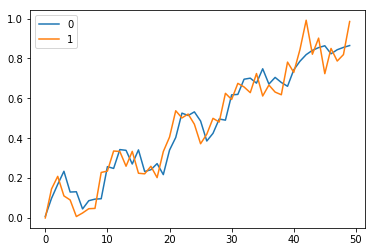

In [11]:
pd.DataFrame([output_list[0].flatten(),ydata.flatten()]).T.plot()